In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
def parser(x):
    return datetime.strptime(x, '%Y-%m-%d %H:%M')

In [3]:
df = pd.read_csv('./daejeon_vds16.csv',  date_parser=parser)
df.head()

,Date,ToVol,SmVol,MeVol,LaVol,Speed,Occ.Rate
0,2017-04-02 0:00,43,34,9,0,50.3,1.90
1,2017-04-02 0:05,45,32,13,0,58.9,1.84
2,2017-04-02 0:10,46,34,12,0,50.6,1.87
3,2017-04-02 0:15,45,36,9,0,50.9,1.72
4,2017-04-02 0:20,27,13,13,1,62.2,1.12


In [4]:
date_time = pd.to_datetime(df.pop('Date'), format='%Y-%m-%d %H:%M')

Here is the evolution of a few features over time:

C:\Python37\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Python37\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Python37\lib\site-packages\pandas\plotting\_matplotlib\tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Python37\lib\site-packages\pandas\plotting\_matplotlib\tools.py:304: MatplotlibDeprecationWarning: 
T

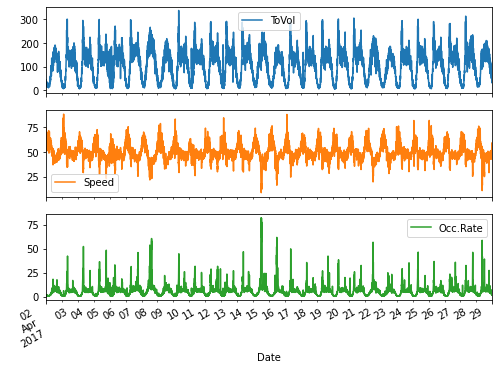

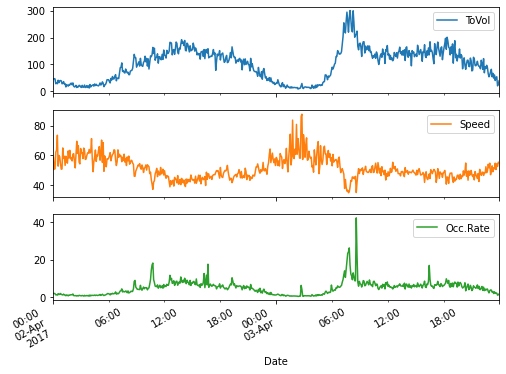

In [5]:
plot_cols = ['ToVol', 'Speed', 'Occ.Rate']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:576]
plot_features.index = date_time[:576]
_ = plot_features.plot(subplots=True)

Next, look at the statistics of the dataset:

In [6]:
df.describe()

,ToVol,SmVol,MeVol,LaVol,Speed,Occ.Rate
count,8064.000000,8064.000000,8064.000000,8064.000000,8064.000000,8064.000000
mean,110.459945,79.353299,29.948537,1.158110,49.327431,6.166941
std,63.954451,46.802106,19.081136,1.530192,7.921856,6.739946
min,6.000000,2.000000,0.000000,0.000000,9.100000,0.230000
25%,50.000000,35.000000,13.000000,0.000000,44.900000,2.140000
50%,122.000000,87.000000,29.000000,1.000000,48.500000,5.550000
75%,155.000000,111.000000,44.000000,2.000000,54.200000,7.290000
max,338.000000,250.000000,145.000000,16.000000,87.800000,82.100000


In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ToVol,8064.0,110.459945,63.954451,6.00,50.00,122.00,155.00,338.0
SmVol,8064.0,79.353299,46.802106,2.00,35.00,87.00,111.00,250.0
MeVol,8064.0,29.948537,19.081136,0.00,13.00,29.00,44.00,145.0
LaVol,8064.0,1.158110,1.530192,0.00,0.00,1.00,2.00,16.0
Speed,8064.0,49.327431,7.921856,9.10,44.90,48.50,54.20,87.8
Occ.Rate,8064.0,6.166941,6.739946,0.23,2.14,5.55,7.29,82.1


## Feature Engineering

Text(0, 0.5, 'Total Volume [numbers]')

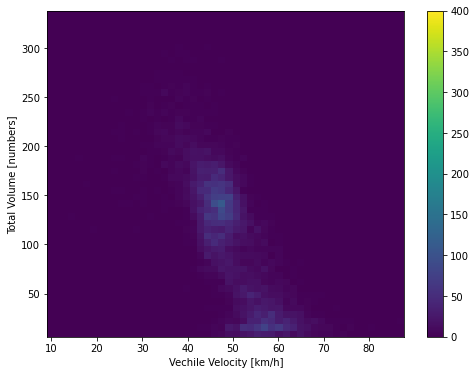

In [8]:
plt.hist2d( df['Speed'], df['ToVol'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Vechile Velocity [km/h]')
plt.ylabel('Total Volume [numbers]')

Text(0, 0.5, 'Total Volume')

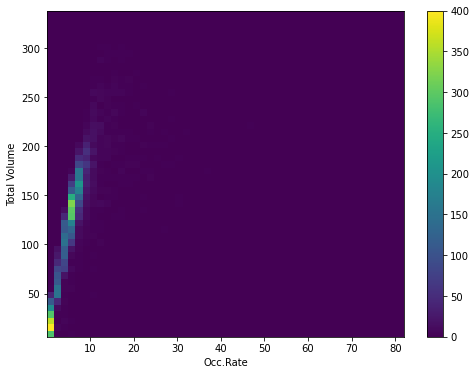

In [9]:
plt.hist2d(df['Occ.Rate'], df['ToVol'],bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Occ.Rate')
plt.ylabel('Total Volume')

You'll use a (70%, 20%, 10%) split for the training, validation, and test sets. Note the data is not being randomly shuffled before splitting. This is for two reasons:

It ensures that chopping the data into windows of consecutive samples is still possible.
It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [10]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [11]:
df.columns

Index(['ToVol', 'SmVol', 'MeVol', 'LaVol', 'Speed', 'Occ.Rate'], dtype='object')

In [12]:
df.shape

(8064, 6)

Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling: 

subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So, in the interest of simplicity this tutorial uses a simple average.

In [13]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

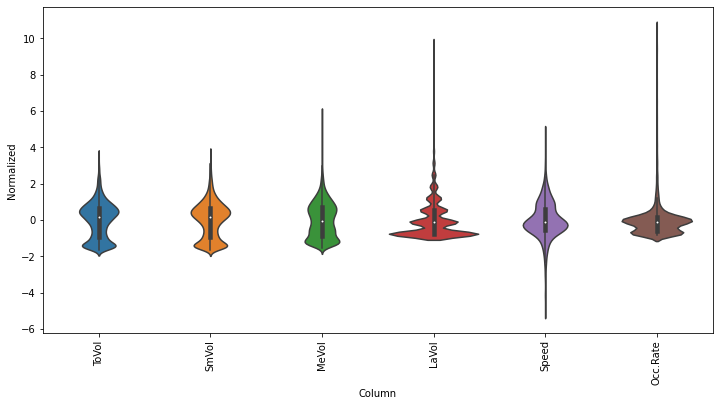

In [14]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data.

The main features of the input windows are:

The width (number of time steps) of the input and label windows.
The time offset between them.
Which features are used as inputs, labels, or both.
This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

Single-output, and multi-output predictions.
Single-time-step and multi-time-step predictions.
This section focuses on implementing the data windowing so that it can be reused for all of those models.

Depending on the task and type of model you may want to generate a variety of data windows. Here are some examples:


1) For example, to make a single prediction 2 hours (24) into the 
future, given 2 hours of history, you might define a window like this:
![](https://www.tensorflow.org/tutorials/structured_data/images/raw_window_24h.png)

2) A model that makes a prediction 30 minutes (#6) into the future, given 30 mimutes of history, would need a window like this:
![](https://www.tensorflow.org/tutorials/structured_data/images/raw_window_1h.png)

he rest of this section defines a WindowGenerator class. This class can:

Handle the indexes and offsets as shown in the diagrams above.
Split windows of features into (features, labels) pairs.
Plot the content of the resulting windows.
Efficiently generate batches of these windows from the training, evaluation, and test data, using tf.data.Datasets.

1. Indexes and offsets
Start by creating the WindowGenerator class. The __init__ method includes all the necessary logic for the input and label indices.

It also takes the training, evaluation, and test DataFrames as input. These will be converted to tf.data.Datasets of windows later.

In [15]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None): 
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
            self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
            
        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [16]:
## ORIG
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    


In [17]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['ToVol'])
w1

In [18]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['ToVol'])
w2

#2. Split

Given a list of consecutive inputs, the split_window method will convert them to a window of inputs and a window of labels.

The example w2 you define earlier will be split like this:

![](https://www.tensorflow.org/tutorials/structured_data/images/split_window.png)

This diagram doesn't show the features axis of the data, but this ***split_window*** function also handles the **label_columns** so it can be used for both the single output and multi-output examples.

In [19]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    
    return inputs, labels

WindowGenerator.split_window = split_window

In [20]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 6)
Inputs shape: (3, 6, 6)
Labels shape: (3, 1, 1)


Typically, data in TensorFlow is packed into arrays where the outermost index is across examples (the "batch" dimension). The middle indices are the "time" or "space" (width, height) dimension(s). The innermost indices are the features.

The code above took a batch of three 7-time step windows with 6 features at each time step. It splits them into a batch of 6-time step 6-feature inputs, and a 1-time step 1-feature label. The label only has one feature because the WindowGenerator was initialized with label_columns=['ToVol']. Initially, this tutorial will build models that predict single output labels.

#3. Plot
Here is a plot method that allows a simple visualization of the split window:

In [21]:
w2.example = example_inputs, example_labels

In [22]:
def plot(self, model=None, plot_col='ToVol', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)
        
        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index
        
        if label_col_index is None:
            continue
            
        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=64)
        
        if n == 0:
            plt.legend()
    
    plt.xlabel('Time [5 mins]')

WindowGenerator.plot = plot

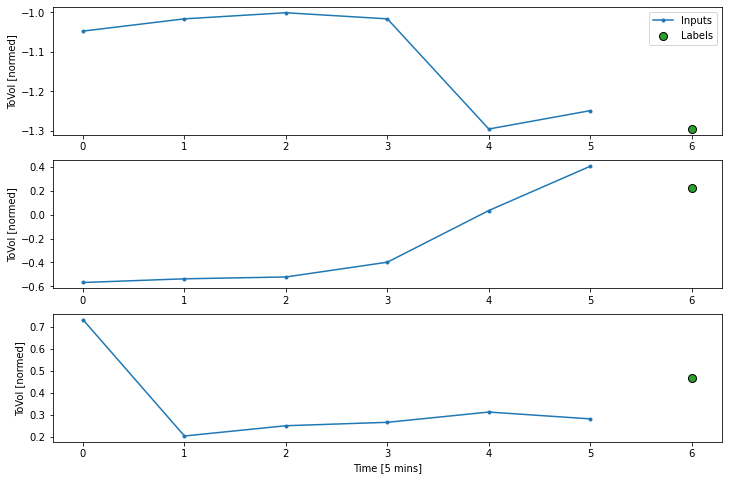

In [23]:
w2.plot()

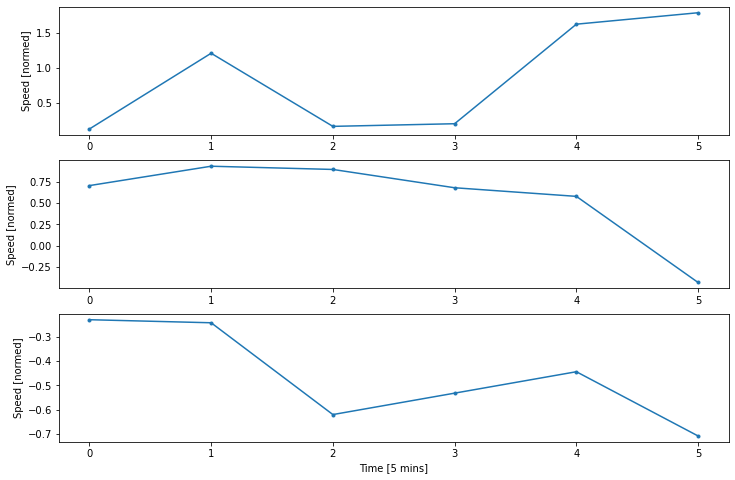

In [24]:
w2.plot(plot_col='Speed')

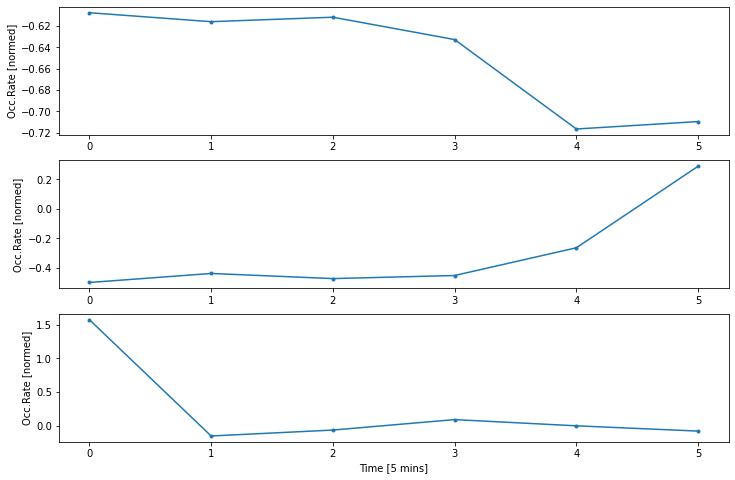

In [25]:
w2.plot(plot_col='Occ.Rate')

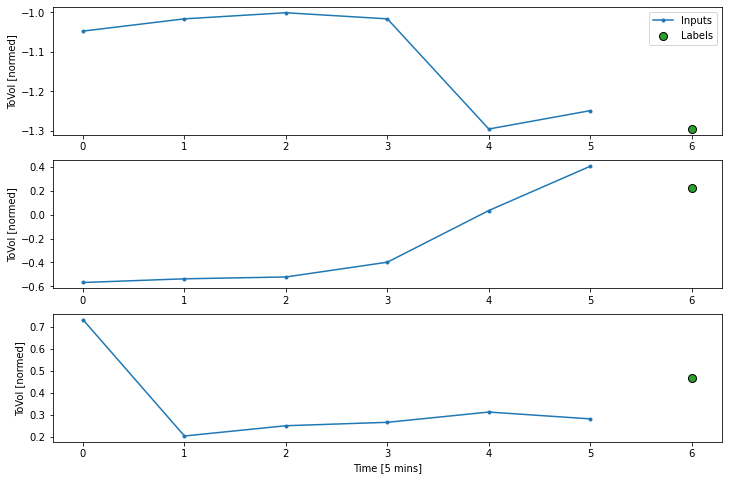

In [26]:
w2.plot(plot_col='ToVol')

#4. Cretate tf.data.Datasets

Finally, this make_dataset method will take a time series DataFrame and convert it to a tf.data.Dataset of (input_window, label_window) pairs using the tf.keras.utils.timeseries_dataset_from_array function:

In [27]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(data=data,
      targets=None, sequence_length=self.total_window_size,
      sequence_stride=1, shuffle=True, batch_size=32,)
    ds = ds.map(self.split_window)
    return ds

WindowGenerator.make_dataset = make_dataset

The WindowGenerator object holds training, validation, and test data.

Add properties for accessing them as tf.data.Datasets using the make_dataset method you defined earlier. Also, add a standard example batch for easy access and plotting:

In [28]:
def train(self):
    return self.make_dataset(self.train_df)
def val(self):
    return self.make_dataset(self.val_df)
def test(self):
    return self.make_dataset(self.test_df)

def example(self):
    # Get and cache an example batch of `inputs, labels` for plotting.
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

In [29]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

In [30]:
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Now, the WindowGenerator object gives you access to the tf.data.Dataset objects, so you can easily iterate over the data.

The Dataset.element_spec property tells you the structure, data types, and shapes of the dataset elements.

In [31]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 6), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Iterating over a Dataset yields concrete batches:

In [32]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 6)
Labels shape (batch, time, features): (32, 1, 1)


#A0. Single Step Models

he simplest model you can build on this sort of data is one that predicts a single feature's value—1 time step (5 minute) into the future based only on the current conditions.

So, start by building models to predict the ToVol value one hour into the future.

![](https://www.tensorflow.org/tutorials/structured_data/images/narrow_window.png)

In [33]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['ToVol'])
single_step_window

The window object creates tf.data.Datasets from the training, validation, and test sets, allowing you to easily iterate over batches of data.

In [34]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 6)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline 

Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

This first task is to predict temperature 5 minute into the future, given the current value of all features. The current values include the current temperature.

So, start with a model that just returns the current temperature as the prediction, predicting "No change". This is a reasonable baseline since temperature changes slowly. Of course, this baseline will work less well if you make a prediction further in the future.

![](https://www.tensorflow.org/tutorials/structured_data/images/baseline.png)

In [35]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [36]:
baseline = Baseline(label_index=column_indices['ToVol'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

51/51 [==============================] - 0s 3ms/step - loss: 0.1074 - mean_absolute_error: 0.2376


That printed some performance metrics, but those don't give you a feeling for how well the model is doing.

The WindowGenerator has a plot method, but the plots won't be very interesting with only a single sample.

So, create a wider WindowGenerator that generates windows 2 hours (#24) of consecutive inputs and labels at a time. The new wide_window variable doesn't change the way the model operates. The model still makes predictions one hour into the future based on a single input time step. Here, the time axis acts like the batch axis: each prediction is made independently with no interaction between time steps:

In [37]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['ToVol'])

wide_window

This expanded window can be passed directly to the same baseline model without any code changes. This is possible because the inputs and labels have the same number of time steps, and the baseline just forwards the input to the output:

![](https://www.tensorflow.org/tutorials/structured_data/images/last_window.png)

In [38]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 6)
Output shape: (32, 24, 1)


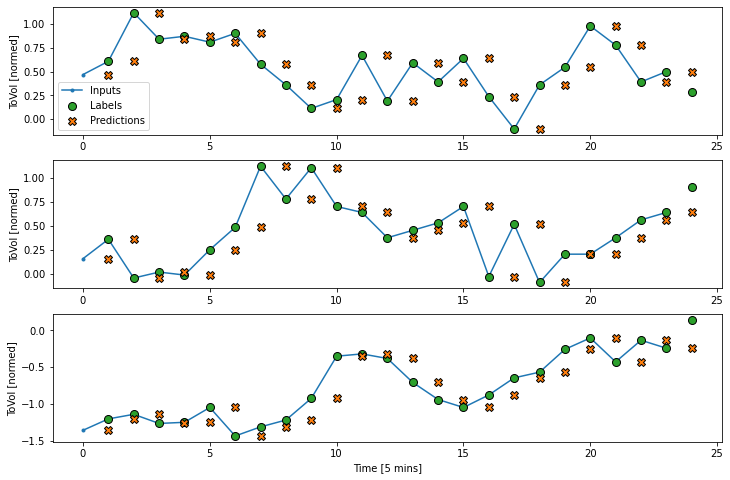

In [39]:
wide_window.plot(baseline)

In the above plots of three examples the single step model is run over the course of 2 hours. This deserves some explanation:

The blue Inputs line shows the input temperature at each time step. The model receives all features, this plot only shows the temperature.
The green Labels dots show the target prediction value. These dots are shown at the prediction time, not the input time. That is why the range of labels is shifted 1 step relative to the inputs.
The orange Predictions crosses are the model's prediction's for each output time step. If the model were predicting perfectly the predictions would land directly on the Labels.

#2 Linear Model 

The simplest trainable model you can apply to this task is to insert linear transformation between the input and output. In this case the output from a time step only depends on that step:

![](https://www.tensorflow.org/tutorials/structured_data/images/narrow_window.png)

A tf.keras.layers.Dense layer with no activation set is a linear model. The layer only transforms the last axis of the data from (batch, time, inputs) to (batch, time, units); it is applied independently to every item across the batch and time axes.

In [40]:
linear = tf.keras.Sequential([tf.keras.layers.Dense(units=1)])

In [41]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 6)
Output shape: (32, 1, 1)


In [42]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [43]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
177/177 [==============================] - 2s 10ms/step - loss: 0.4169 - mean_absolute_error: 0.3870 - val_loss: 0.2271 - val_mean_absolute_error: 0.3439
Epoch 2/20
177/177 [==============================] - 2s 9ms/step - loss: 0.3521 - mean_absolute_error: 0.3812 - val_loss: 0.2113 - val_mean_absolute_error: 0.3380
Epoch 3/20
177/177 [==============================] - 2s 9ms/step - loss: 0.3086 - mean_absolute_error: 0.3707 - val_loss: 0.1970 - val_mean_absolute_error: 0.3296
Epoch 4/20
177/177 [==============================] - 2s 9ms/step - loss: 0.2746 - mean_absolute_error: 0.3595 - val_loss: 0.1835 - val_mean_absolute_error: 0.3199
Epoch 5/20
177/177 [==============================] - 2s 9ms/step - loss: 0.2476 - mean_absolute_error: 0.3482 - val_loss: 0.1708 - val_mean_absolute_error: 0.3097
Epoch 6/20
177/177 [==============================] - 1s 8ms/step - loss: 0.2250 - mean_absolute_error: 0.3365 - val_loss: 0.1596 - val_mean_absolute_error: 0.3001
Epoch 7/20
177/

Like the baseline model, the linear model can be called on batches of wide windows. Used this way the model makes a set of independent predictions on consecutive time steps. The time axis acts like another batch axis. There are no interactions between the predictions at each time step.

![](https://www.tensorflow.org/tutorials/structured_data/images/wide_window.png)

In [44]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 6)
Output shape: (32, 24, 1)


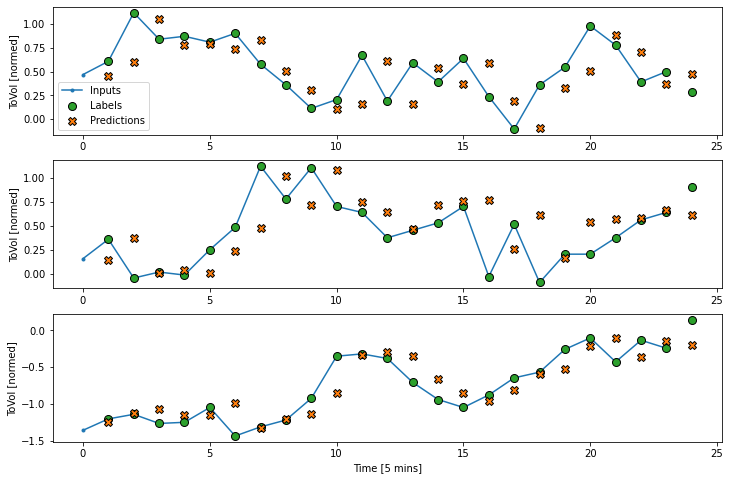

In [45]:
wide_window.plot(linear)

One advantage to linear models is that they're relatively simple to interpret. You can pull out the layer's weights and visualize the weight assigned to each input:

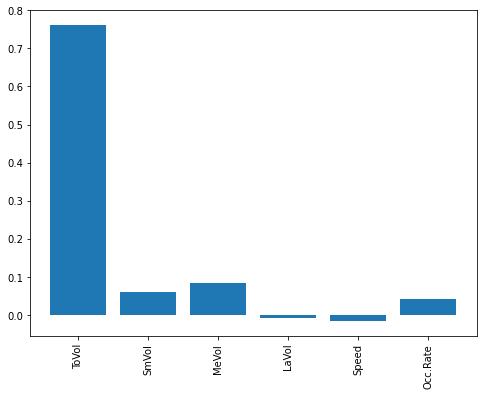

In [46]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Sometimes the model doesn't even place the most weight on the input ToVol. This is one of the risks of random initialization.

#3 Dense Layer

Before applying models that actually operate on multiple time-steps, it's worth checking the performance of deeper, more powerful, single input step models.

Here's a model similar to the linear model, except it stacks several a few Dense layers between the input and the output:

In [47]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
177/177 [==============================] - 3s 13ms/step - loss: 0.1647 - mean_absolute_error: 0.2874 - val_loss: 0.1009 - val_mean_absolute_error: 0.2369
Epoch 2/20
177/177 [==============================] - 2s 14ms/step - loss: 0.1249 - mean_absolute_error: 0.2506 - val_loss: 0.1002 - val_mean_absolute_error: 0.2358
Epoch 3/20
177/177 [==============================] - 2s 14ms/step - loss: 0.1234 - mean_absolute_error: 0.2502 - val_loss: 0.0999 - val_mean_absolute_error: 0.2339
Epoch 4/20
177/177 [==============================] - 2s 14ms/step - loss: 0.1215 - mean_absolute_error: 0.2481 - val_loss: 0.0999 - val_mean_absolute_error: 0.2357
Epoch 5/20
177/177 [==============================] - 2s 13ms/step - loss: 0.1211 - mean_absolute_error: 0.2477 - val_loss: 0.1012 - val_mean_absolute_error: 0.2375
Epoch 6/20
51/51 [==============================] - 0s 7ms/step - loss: 0.1016 - mean_absolute_error: 0.2319


#5. Multi-Step Dense 

A single-time-step model has no context for the current values of its inputs. It can't see how the input features are changing over time. To address this issue the model needs access to multiple time steps when making predictions:


The baseline, linear and dense models handled each time step independently. Here the model will take multiple time steps as input to produce a single output.

Create a WindowGenerator that will produce batches of 3 inputs and 1 labels:

Note that the Window's shift parameter is relative to the end of the two windows.

![](https://www.tensorflow.org/tutorials/structured_data/images/conv_window.png)

In [48]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['ToVol'])

conv_window

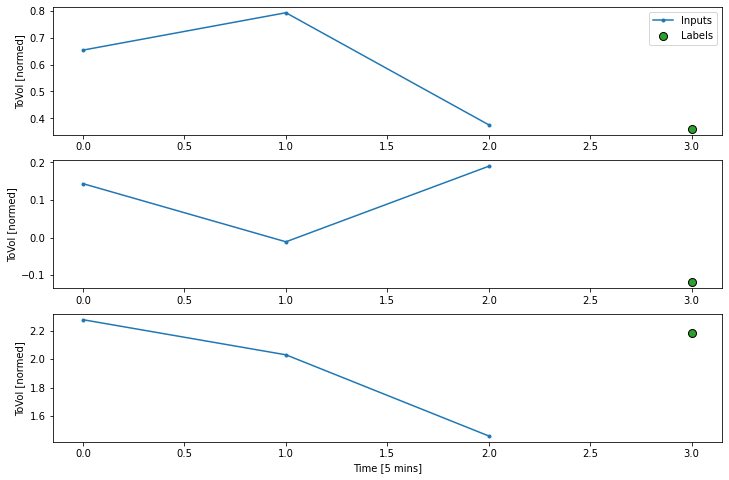

In [49]:
conv_window.plot()
#plt.title("Given 3 inputs, predict 1 into the future.")

You could train a dense model on a multiple-input-step window by adding a tf.keras.layers.Flatten as the first layer of the model:

In [50]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [51]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 6)
Output shape: (32, 1, 1)


In [52]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

51/51 [==============================] - 0s 3ms/step - loss: 0.0842 - mean_absolute_error: 0.2103


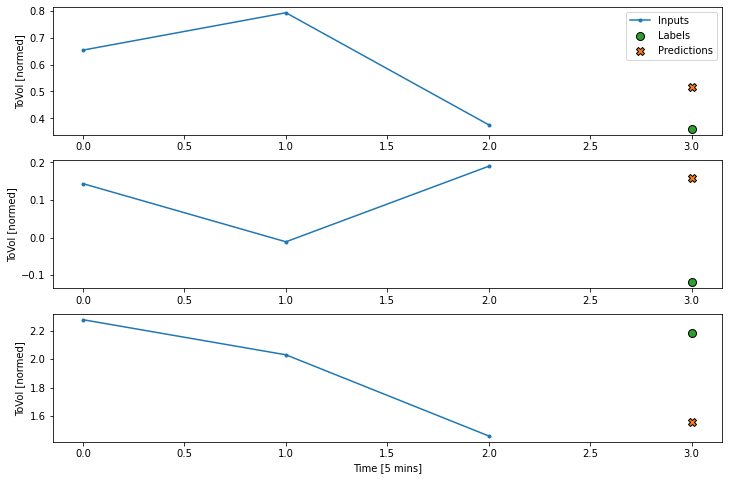

In [53]:
conv_window.plot(multi_step_dense)

The main down-side of this approach is that the resulting model can only be executed on input windows of exactly this shape.

In [54]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 6)

ValueError:Exception encountered when calling layer "sequential_2" (type Sequential).

Input 0 of layer "dense_4" is incompatible with the layer: expected axis -1of input shape to have value 18, but received input with shape (32, 144)

Call arguments received:
  • inputs=tf.Tensor(shape=(32, 24, 6), dtype=float32)
  • training=None
  • mask=None


The convolutional models in the next section fix this problem.

#6 Convolution neural network

A convolution layer (tf.keras.layers.Conv1D) also takes multiple time steps as input to each prediction.

Below is the same model as multi_step_dense, re-written with a convolution.

Note the changes:

The tf.keras.layers.Flatten and the first tf.keras.layers.Dense are replaced by a tf.keras.layers.Conv1D.
The tf.keras.layers.Reshape is no longer necessary since the convolution keeps the time axis in its output.

In [55]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [56]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 6)
Output shape: (32, 1, 1)


Train and evaluate it on the conv_window and it should give performance similar to the multi_step_dense model.

In [57]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

51/51 [==============================] - 0s 6ms/step - loss: 0.0833 - mean_absolute_error: 0.2147


The difference between this conv_model and the multi_step_dense model is that the conv_model can be run on inputs of any length. The convolutional layer is applied to a sliding window of inputs:

![](https://www.tensorflow.org/tutorials/structured_data/images/wide_conv_window.png)

If you run it on wider input, it produces wider output:

In [58]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 6)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


Note that the output is shorter than the input. To make training or plotting work, you need the labels, and prediction to have the same length. So build a WindowGenerator to produce wide windows with a few extra input time steps so the label and prediction lengths match:

In [59]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['ToVol'])

wide_conv_window

In [60]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 6)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


Now, you can plot the model's predictions on a wider window. Note the 3 input time steps before the first prediction. Every prediction here is based on the 3 preceding time steps:

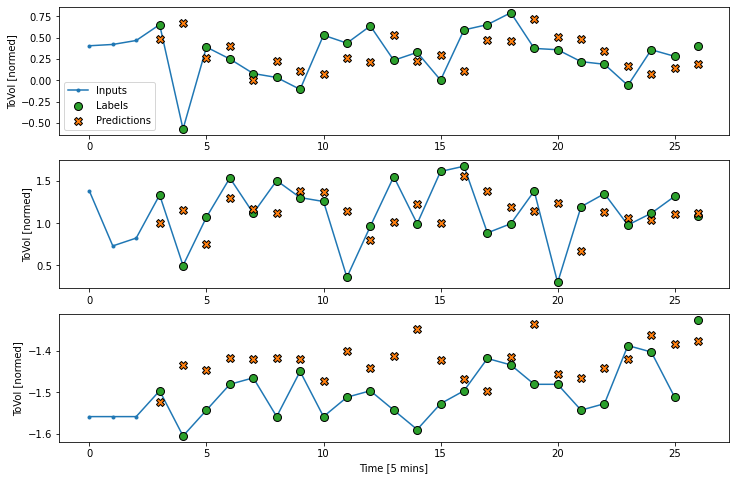

In [61]:
wide_conv_window.plot(conv_model)

#7 LSTM & Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

You can learn more in the Text generation with an RNN tutorial and the Recurrent Neural Networks (RNN) with Keras guide.

In this tutorial, you will use an RNN layer called Long Short-Term Memory (tf.keras.layers.LSTM).

### return_sequences : False 
An important constructor argument for all Keras RNN layers, such as tf.keras.layers.LSTM, is the return_sequences argument. This setting can configure the layer in one of two ways:

If False, the default, the layer only returns the output of the final time step, giving the model time to warm up its internal state before making a single prediction:

![](https://www.tensorflow.org/tutorials/structured_data/images/lstm_1_window.png)

### Stacking RNN Layers

if *** return_sequences : True***

If True, the layer returns an output for each input. This is useful for:
Stacking RNN layers.
Training a model on multiple time steps simultaneously.

![](https://www.tensorflow.org/tutorials/structured_data/images/lstm_many_window.png)

In [62]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

With return_sequences=True, the model can be trained on 24 hours of data at a time.

In [63]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 6)
Output shape: (32, 24, 1)


In [64]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

50/50 [==============================] - 1s 8ms/step - loss: 0.0679 - mean_absolute_error: 0.1947


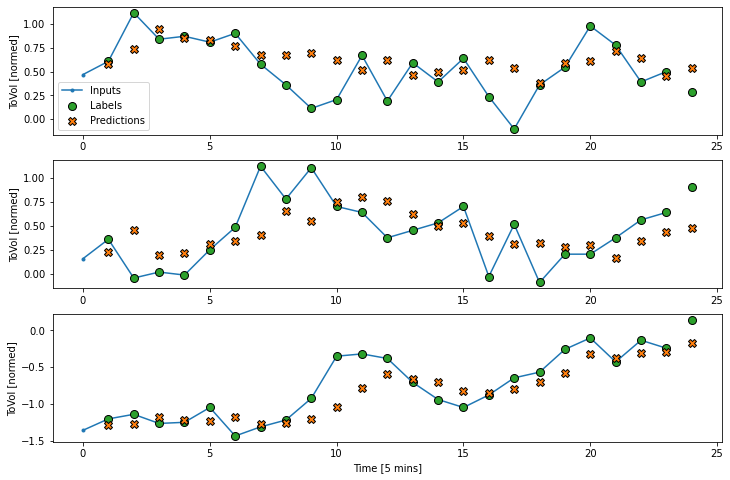

In [65]:
wide_window.plot(lstm_model)

## Performance

With this dataset typically each of the models does slightly better than the one before it:

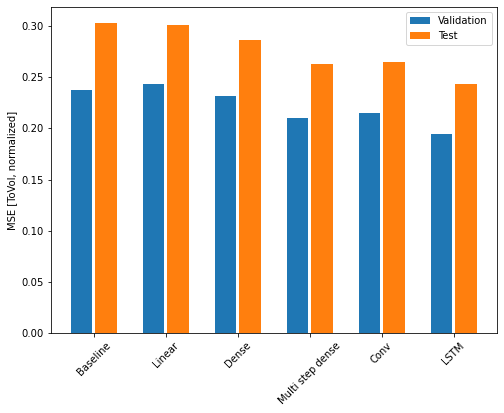

In [66]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('MSE [ToVol, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()